In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import imutils
from PIL import Image
import skimage.measure
from pyzbar.pyzbar import decode
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
import argparse

In [40]:
def get_files(folder_path, ext=[], return_full_path=False):
    _files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f[-3:] in ext]
    if return_full_path:
        _files = [os.path.join(folder_path, f) for f in _files]
    return _files


def get_msers(gray):
    mser = cv2.MSER_create()
    regions, _ = mser.detectRegions(gray)
    hulls = [cv2.convexHull(p.reshape(-1, 1, 2)) for p in regions]
    return regions, hulls


def extract_features(hull):
    
    mask = np.zeros(gray.shape, np.uint8)
    mask = cv2.drawContours(mask, [hull], -1, 255, -1)
    
    mean_intensity = cv2.mean(gray, mask = mask)
    area = cv2.contourArea(hull)

    (x, y), (width, height), angle = cv2.minAreaRect(hull)
    aspect_ratio = max(width, height) / (min(width, height) + 0.01)
    
    features = {'mean_intensity': mean_intensity[0], 
                'area': area, 
                'aspect_ratio': aspect_ratio, 
                'angle': angle,
                'length': max(width, height)}
    
    return features


def classify(feats):
    # if feats['mean_intensity'] < 100 and feats['area'] > 1500 and feats['aspect_ratio'] > 10.0:
    if feats['length'] > 100.0 and feats['aspect_ratio'] > 10.0:
        return 1
    else:
        return 0


def get_rotated_cropped_image(image, rect):
    
    (x, y), (width, height), angle = rect
    img_copy = image.copy()
    
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    
    Xs = [x[0] for x in box]
    Ys = [y[1] for y in box]
    x1 = min(Xs)
    y1 = min(Ys)
    x2 = max(Xs)
    y2 = max(Ys)

    center = (int((x1+x2)/2), int((y1+y2)/2))
    size = (int(x2-x1), int(y2-y1))

    rotation_matrix = cv2.getRotationMatrix2D((size[0]/2, size[1]/2), angle-90.0, 1.0)

    cropped_barcode_reg = cv2.getRectSubPix(img_copy, size, center)
    
    # Plot
    fig, axs = plt.subplots(1, 1, figsize=(5,5))
    axs.imshow(cropped_barcode_reg)
    plt.title("getRectSubPix")
    plt.show()

    cropped_barcode_reg = cv2.warpAffine(cropped_barcode_reg, rotation_matrix, size)
    
    # Plot
    fig, axs = plt.subplots(1, 1, figsize=(5,5))
    axs.imshow(cropped_barcode_reg)
    plt.title("warpAffine")
    plt.show()
    
    cropped_width = width
    cropped_height = height

    cropped_barcode_reg_tight = cv2.getRectSubPix(cropped_barcode_reg, 
                                                  (int(cropped_height), int(cropped_width)), 
                                                  (size[0]/2, size[1]/2))

    if cropped_barcode_reg_tight.shape[0] > cropped_barcode_reg_tight.shape[1]:
        cropped_barcode_reg_tight = cv2.rotate(cropped_barcode_reg_tight, cv2.ROTATE_90_CLOCKWISE)
        
    # Plot
    fig, axs = plt.subplots(1, 1, figsize=(5,5))
    axs.imshow(cropped_barcode_reg_tight)
    plt.title("Final Crop")
    plt.show()

    return cropped_barcode_reg_tight


def get_barcode_region(hulls, save_detection_results=False, file_name=None):
    
    _features = []
    selected_hulls = []
    for index, hull in enumerate(hulls):    
        features = extract_features(hull)
        _features.append(features)
        if classify(features) == 1:
            selected_hulls.append(hull)
            
    df = pd.DataFrame(_features)
    nc = df.shape[1]
    fig, axs = plt.subplots(1, nc, figsize=(5*nc,5))
    for i in range(nc):
        axs[i].hist(df.iloc[:,i], bins=100)
        axs[i].set_xlabel(df.columns[i])
    plt.show()

    if len(selected_hulls) == 0:
        return np.zeros((256, 256), np.uint8)
            
    mask = np.zeros(gray.shape, np.uint8)
    mask_all = cv2.drawContours(mask, selected_hulls, -1, 255, -1)
    
    # Plot
    fig, axs = plt.subplots(1, 1, figsize=(5,5))
    axs.imshow(mask_all, cmap="Greys_r")
    plt.title("1. Classification Output")
    plt.show()
    
    kernel = np.ones((5,5), np.uint8)
    mask_d = cv2.dilate(mask_all, kernel, iterations=10)
    
    # Plot
    fig, axs = plt.subplots(1, 1, figsize=(5,5))
    axs.imshow(mask_d, cmap="Greys_r")
    plt.title("2. Dilated Mask")
    plt.show()
    
    cropped_barcode_regions = []
    labeled_image, count = skimage.measure.label(mask_d, connectivity=2, return_num=True)
    
    # Plot
    fig, axs = plt.subplots(1, 1, figsize=(5,5))
    axs.imshow(labeled_image)
    plt.title("3. Connected Components")
    plt.show()
    
    for label in range(1, count+1):
        mask_i = np.zeros((labeled_image.shape[0], labeled_image.shape[1]), dtype=np.uint8)
        mask_i[labeled_image == label] = 1
        area = np.sum(mask_i)
        if area > 2500:
            contours, hierarchy = cv2.findContours(mask_i, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            # Plot
            contours_image = np.zeros((gray.shape[0], gray.shape[1], 3), np.uint8)
            contours_image = cv2.drawContours(contours_image, contours, -1, (0,255,0), 3)
            fig, axs = plt.subplots(1, 1, figsize=(5,5))
            axs.imshow(contours_image)
            plt.title("4. Contours, Component={}".format(label))
            plt.show()
            
            rect = cv2.minAreaRect(contours[0])
            
            # Plot
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            contours_image = np.zeros((gray.shape[0], gray.shape[1], 3), np.uint8)
            contours_image = cv2.drawContours(contours_image, [box], -1, (0,255,0), 3)
            fig, axs = plt.subplots(1, 1, figsize=(5,5))
            axs.imshow(contours_image)
            plt.title("5. Rotated BB, Component={}".format(label))
            plt.show()
            
            cropped_barcode_reg = get_rotated_cropped_image(gray, rect)

            _cropped_barcode_regions = [cropped_barcode_reg, 
                                        cropped_barcode_reg[::-1,:],
                                        cropped_barcode_reg[:,::-1],
                                        cropped_barcode_reg[::-1,::-1]]

            cropped_barcode_regions.extend(_cropped_barcode_regions)
            if save_detection_results:
                selected_contours.append(contours)

    return cropped_barcode_regions


def get_barcode_region_cnn(model, gray, tile_size=(64,64), save_detection_results=False, file_name=None):

    _gray = gray.copy()
    _gray = _gray.astype(np.float32)
    _gray /= 255.0

    H = tile_size[0]
    W = tile_size[1]
    slices = dict([((x,y), np.expand_dims(_gray[y:y+H,x:x+W], axis=2)) for y in range(0,_gray.shape[0],H) for x in range(0,_gray.shape[1],W)])
    
    positive_coords = []
    negative_coords = []
    mask = np.zeros(gray.shape, np.uint8)

    for index, (x,y) in enumerate(slices):
        sz = slices[(x,y)].shape
        if sz[0] == H and sz[1] == W:
            if classify_cnn(model, slices[(x,y)]) == 1:
                mask[y:y+H,x:x+W] = 1
                positive_coords.append((x,y))
            else:
                negative_coords.append((x,y))

    if len(positive_coords) == 0:
        return np.zeros((256, 256), np.uint8)
    
    # Plot
    fig, axs = plt.subplots(1, 1, figsize=(5,5))
    axs.imshow(mask, cmap="Greys_r")
    plt.title("1. Classification Output")
    plt.show()

    kernel = np.ones((5,5), np.uint8)
    mask_d = cv2.erode(mask, kernel, iterations=10)
    # mask_d = cv2.dilate(mask_d, kernel, iterations=10)
    
    # Plot
    fig, axs = plt.subplots(1, 1, figsize=(5,5))
    axs.imshow(mask_d, cmap="Greys_r")
    plt.title("2. Dilated Mask")
    plt.show()

    if save_detection_results:
        save_detections(gray, positive_coords, negative_coords, tile_size, os.path.join("../results/debug/", "detection_" + file_name))
        plot(mask, os.path.join("../results/debug/", "detection_mask_" + file_name))
        plot(mask_d, os.path.join("../results/debug/", "detection_mask_dilated" + file_name))

    # kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    # closing = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    cropped_barcode_regions = []
    # N, labels = cv2.connectedComponents(mask, 4, cv2.CV_32S)

    if save_detection_results:
        selected_contours = []

    labeled_image, count = skimage.measure.label(mask_d, connectivity=2, return_num=True)
    
    # Plot
    fig, axs = plt.subplots(1, 1, figsize=(5,5))
    axs.imshow(labeled_image)
    plt.title("3. Connected Components")
    plt.show()
    
    for label in range(1, count+1):
        mask_i = np.zeros((labeled_image.shape[0], labeled_image.shape[1]), dtype=np.uint8)
        mask_i[labeled_image == label] = 1
        area = np.sum(mask_i)
        if area > 2500:
            contours, hierarchy = cv2.findContours(mask_i, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            # Plot
            contours_image = np.zeros((gray.shape[0], gray.shape[1], 3), np.uint8)
            contours_image = cv2.drawContours(contours_image, contours, -1, (0,255,0), 3)
            fig, axs = plt.subplots(1, 1, figsize=(5,5))
            axs.imshow(contours_image)
            plt.title("4. Contours, Component={}".format(label))
            plt.show()
            
            rect = cv2.minAreaRect(contours[0])
            
            # Plot
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            contours_image = np.zeros((gray.shape[0], gray.shape[1], 3), np.uint8)
            contours_image = cv2.drawContours(contours_image, [box], -1, (0,255,0), 3)
            fig, axs = plt.subplots(1, 1, figsize=(5,5))
            axs.imshow(contours_image)
            plt.title("5. Rotated BB, Component={}".format(label))
            plt.show()
            
            cropped_barcode_reg = get_rotated_cropped_image(gray, rect)

            _cropped_barcode_regions = [cropped_barcode_reg, 
                                        cropped_barcode_reg[::-1,:],
                                        cropped_barcode_reg[:,::-1],
                                        cropped_barcode_reg[::-1,::-1]]

            cropped_barcode_regions.extend(_cropped_barcode_regions)
            if save_detection_results:
                selected_contours.append(contours)

    if save_detection_results:
        save_selected_detections(selected_contours, mask_d, os.path.join("../results/debug/", "min_area_rect_" + file_name))

    return cropped_barcode_regions


def show_barcode(cropped_barcode_reg, outpath=None):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(cropped_barcode_reg, cmap='Greys_r', vmin=0, vmax=255)
    
    if outpath is not None:
        plt.savefig(outpath)
        plt.close()
    else:
        plt.show()


def get_ground_truth_barcode(file_name):
    with open(file_name, 'r') as file:
        data = file.read()
    return data


def load_model(model_dir, epoch):
    model = tf.keras.models.load_model(os.path.join(model_dir, "{0:02d}.h5".format(epoch)))
    return model


def classify_cnn(model, image):
    p = model(np.array([image]), training=False)
    return np.argmax(p[0])

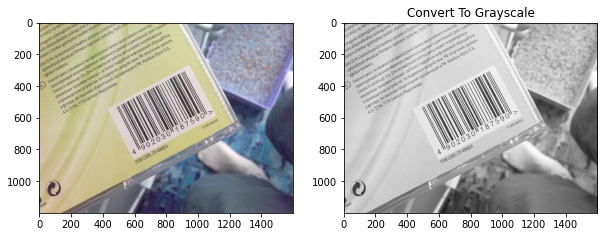

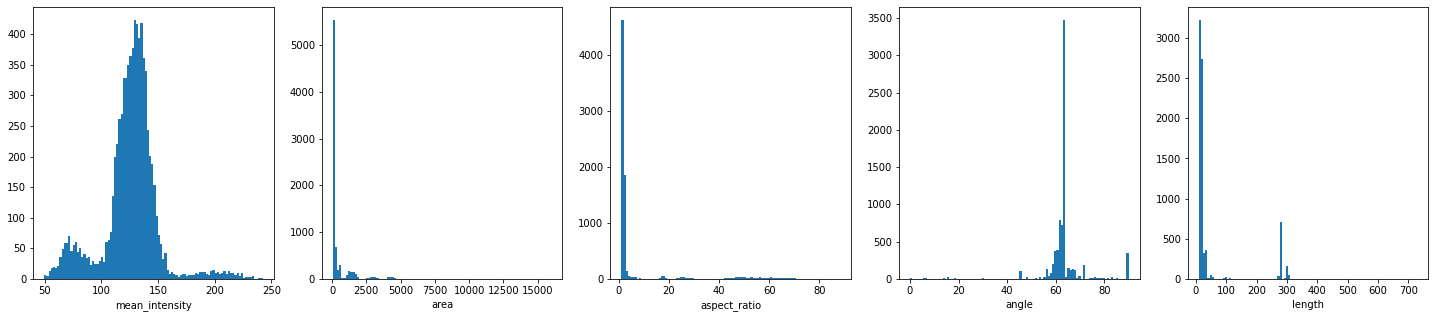

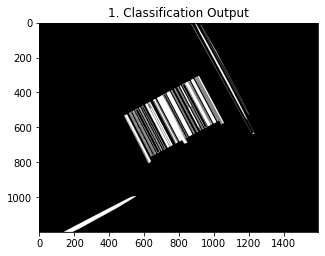

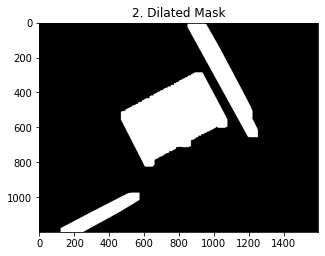

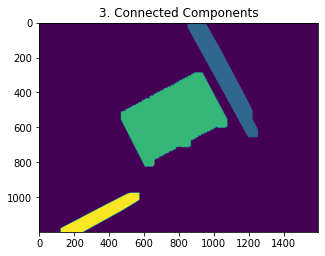

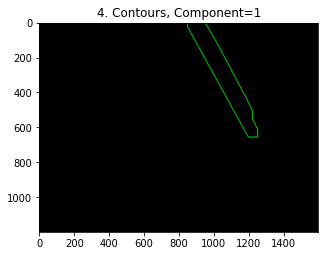

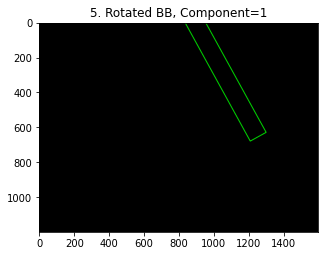

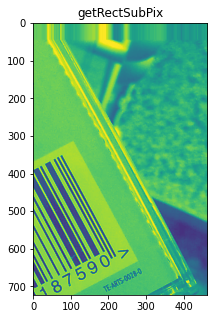

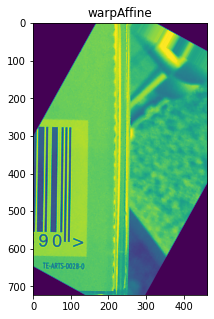

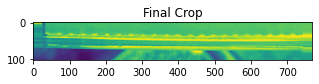

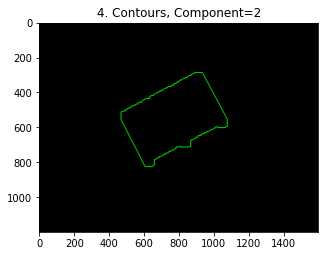

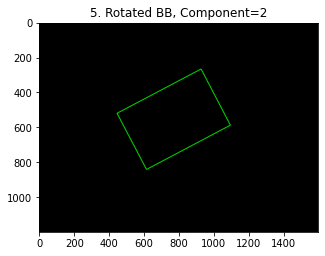

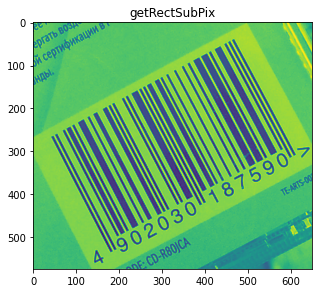

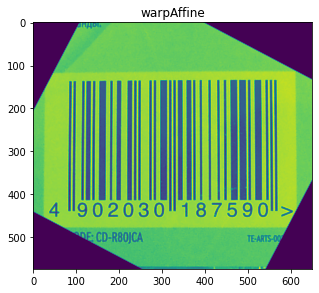

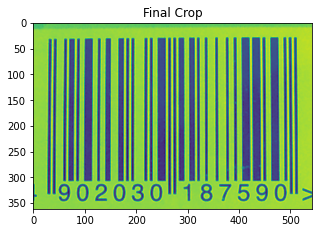

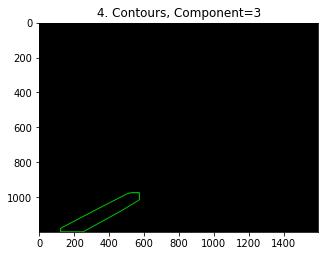

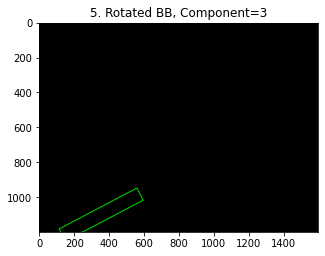

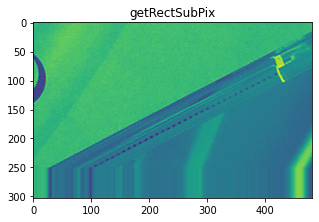

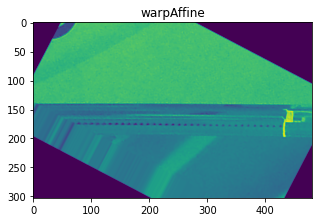

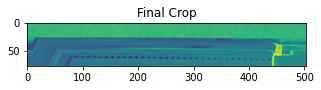

In [41]:
image = cv2.imread(os.path.join("../data/BarcodeDatasets", "Dataset1", "05102009082.jpg"))
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

fig, axs = plt.subplots(1, 2, figsize=(10,20))
axs[0].imshow(image)
axs[1].imshow(gray, cmap="Greys_r")
plt.title("Convert To Grayscale")
plt.show()

regions, hulls = get_msers(gray)
cropped_barcode_reg = get_barcode_region(hulls)

# _model = load_model("../models/barcode_detector", 192)
# cropped_barcode_regions = get_barcode_region_cnn(_model, gray, tile_size=(64,64), save_detection_results=False)